In [57]:
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import chart_studio.plotly as py
import chart_studio
import matplotlib.pyplot as plt

chart_studio.tools.set_credentials_file(username='oystein.nerva', api_key='0ODcZ6UisJ8n0AjEQt9N')

In [58]:
url = 'https://github.com/NRVA/COVID19_Norge/raw/master/COVID19_fhi_data_fylke.csv'
data = pd.read_csv(url, sep=';')
trejectory = data.copy()
data

,Fylke,02.mar.20,03.mar.20,04.mar.20,05.mar.20,06.mar.20,07.mar.20,08.mar.20,09.mar.20,10.mar.20,...,06.apr.20,07.apr.20,08.apr.20,09.apr.20,10.apr.20,11.apr.20,12.apr.20,13.apr.20,14.apr.20,15.apr.20
0,Agder,2,3,3,7,7,9,9,17,19,...,231,236,243,249,253,258,261,263,266,268
1,Innlandet,0,0,3,4,12,12,12,14,16,...,369,373,381,387,389,392,395,396,398,399
2,Møre og Romsdal,0,0,1,2,2,2,2,4,5,...,115,115,116,116,116,116,116,117,117,117
3,Nordland,0,0,0,0,1,2,3,3,3,...,76,77,84,86,87,90,91,95,95,97
4,Oslo,7,7,14,18,23,29,35,35,51,...,1626,1673,1730,1780,1827,1866,1893,1926,1960,1985
5,Rogaland,0,0,3,6,11,14,19,25,33,...,377,378,379,379,379,379,380,380,380,382
6,Troms og Finnmark,1,2,2,2,6,6,6,6,6,...,181,184,185,187,188,190,190,193,197,200
7,Trøndelag,0,0,1,7,15,18,19,22,22,...,372,375,377,388,391,393,400,400,403,405
8,Vestfold og Telemark,0,0,0,2,2,2,3,5,5,...,224,226,234,237,237,238,241,247,247,250
9,Vestland,9,12,17,22,24,24,24,28,31,...,573,578,603,633,646,648,670,670,684,729


In [3]:
url = "https://github.com/NRVA/COVID19_Norge/raw/master/Fylkestilhorighet_2020.csv"
fylker = pd.read_csv(url, sep=';')
fylker

,Fylke,RHF,Befolkning
0,Agder,Helse Sør-Øst,307231
1,Innlandet,Helse Sør-Øst,371385
2,Møre og Romsdal,Helse Midt-Norge,265238
3,Nordland,Helse Nord,241235
4,Oslo,Helse Sør-Øst,693494
5,Rogaland,Helse Vest,479892
6,Troms og Finnmark,Helse Nord,243311
7,Trøndelag,Helse Midt-Norge,468702
8,Vestfold og Telemark,Helse Sør-Øst,419396
9,Vestland,Helse Vest,636531


In [59]:
df = data.melt(id_vars=['Fylke']).copy()
df['variable'] = pd.to_datetime(df['variable'], errors='coerce')
df = df.groupby(["Fylke", pd.Grouper(key="variable", freq="d")]).max().reset_index()
df = df.pivot(index="variable", columns="Fylke", values="value")

restart = df.copy()
endring = df.copy().diff(1)

df.head()

Fylke,Agder,Innlandet,Møre og Romsdal,Nordland,Oslo,Rogaland,Troms og Finnmark,Trøndelag,Vestfold og Telemark,Vestland,Viken
variable,,,,,,,,,,,
2020-03-02,2,0,0,0,7,0,1,0,0,9,5
2020-03-03,3,0,0,0,7,0,2,0,0,12,8
2020-03-04,3,3,1,0,14,3,2,1,0,17,19
2020-03-05,7,4,2,0,18,6,2,7,2,22,23
2020-03-06,7,12,2,1,23,11,6,15,2,24,26


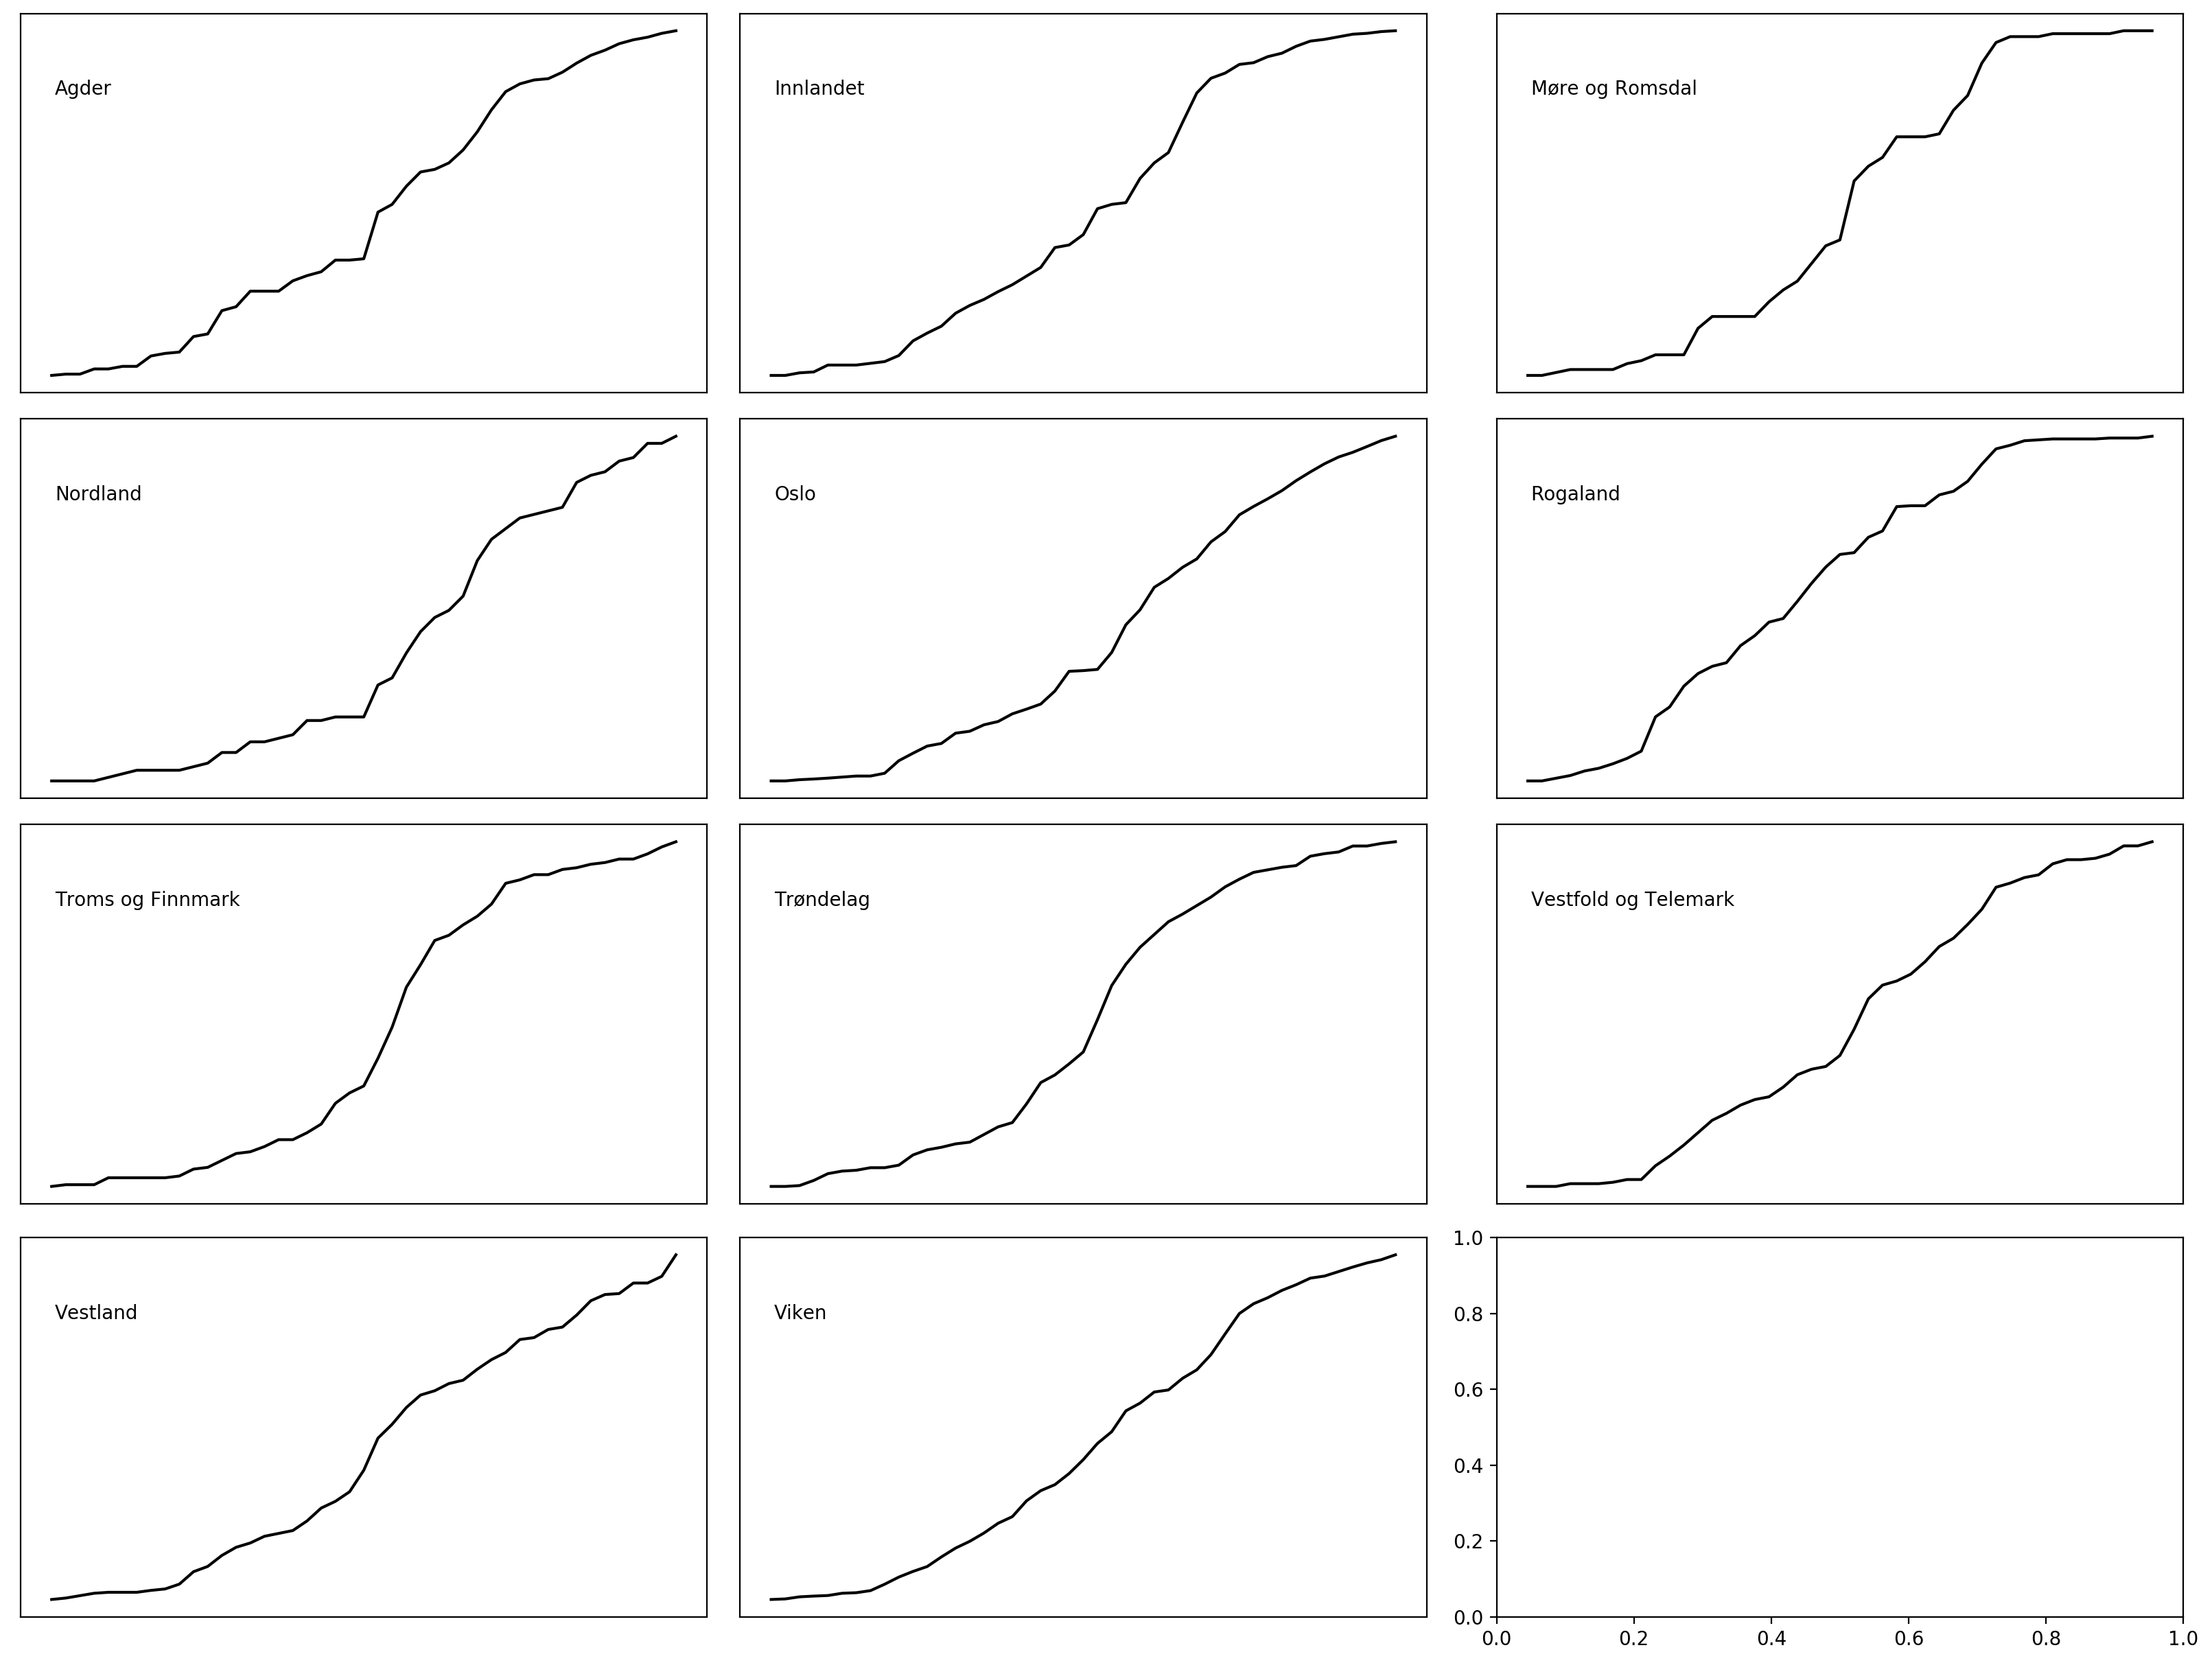

In [60]:
fig = plt.figure(figsize=(16,12), dpi=200, constrained_layout=True)

axs = fig.subplots(nrows=4, ncols=3)

for i in range(len(df.columns)):
    axs.flat[i].plot(df.index, df.iloc[:,i], color='black')
    axs.flat[i].get_xaxis().set_ticks([])
    axs.flat[i].get_yaxis().set_ticks([])
    axs.flat[i].annotate(df.iloc[:,i].name, (0.05, 0.8),xycoords='axes fraction', va='center', ha='left')
    
fig.savefig('fylker_matrix.png')

In [25]:
unstacked = df.unstack().reset_index()

unstacked = unstacked[pd.to_datetime(unstacked["variable"]) >= pd.to_datetime("2020-02-25")]

unstacked.head()

,Fylke,variable,0
0,Agder,2020-03-02,2
1,Agder,2020-03-03,3
2,Agder,2020-03-04,3
3,Agder,2020-03-05,7
4,Agder,2020-03-06,7


# moment

In [61]:
roc = df.copy()
roc = roc.pct_change(periods=2)*100/3

roc.iloc[[-1]].melt()
roc1 = roc.iloc[[-1]].melt().rename(columns={"value": "Vekstrate"}).sort_values(by=['Vekstrate'], ascending=True)
lastweek = roc.iloc[[-7]].melt().rename(columns={"value": "- 1 uke"})

vekst = roc1.merge(lastweek, how="left", on="Fylke")
vekst.head()

,Fylke,Vekstrate,- 1 uke
0,Møre og Romsdal,0.000000,0.289855
1,Rogaland,0.175439,0.088183
2,Innlandet,0.252525,1.251117
3,Vestfold og Telemark,0.404858,1.622419
4,Trøndelag,0.416667,1.155556


In [62]:
vekst["dtime"] = np.log(2)/np.log(1+(vekst["Vekstrate"]/100))
#vekst["dtime"] = (72/(vekst["Vekstrate"]))
vekst["momentum"] = vekst["Vekstrate"]-vekst["- 1 uke"]
vekst["momentum"] = vekst["momentum"].apply(lambda x: "Avtagende" if x < 0 else "Tiltagende")
vekst["text"] = "Hver "+vekst["dtime"].round(0).astype(str)+" dag"
vekst["Vekstrate"] = vekst["Vekstrate"].round(2)
vekst["- 1 uke"] = vekst["- 1 uke"].round(2)
vekst = vekst.merge(fylker, how="left", on="Fylke")

vekst

,Fylke,Vekstrate,- 1 uke,dtime,momentum,text,RHF,Befolkning
0,Møre og Romsdal,0.00,0.29,inf,Avtagende,Hver inf dag,Helse Midt-Norge,265238
1,Rogaland,0.18,0.09,395.440365,Tiltagende,Hver 395.0 dag,Helse Vest,479892
2,Innlandet,0.25,1.25,274.832711,Avtagende,Hver 275.0 dag,Helse Sør-Øst,371385
3,Vestfold og Telemark,0.40,1.62,171.553694,Avtagende,Hver 172.0 dag,Helse Sør-Øst,419396
4,Trøndelag,0.42,1.16,166.701657,Avtagende,Hver 167.0 dag,Helse Midt-Norge,468702
5,Agder,0.63,1.84,109.724834,Avtagende,Hver 110.0 dag,Helse Sør-Øst,307231
6,Nordland,0.70,3.90,99.119643,Avtagende,Hver 99.0 dag,Helse Nord,241235
7,Viken,0.80,1.32,87.053990,Avtagende,Hver 87.0 dag,Helse Sør-Øst,1241165
8,Oslo,1.02,2.13,68.227417,Avtagende,Hver 68.0 dag,Helse Sør-Øst,693494
9,Troms og Finnmark,1.21,0.54,57.679053,Tiltagende,Hver 58.0 dag,Helse Nord,243311


In [63]:
from datetime import datetime

legend = [i for i in vekst["RHF"].dropna().unique()]
legend.sort()

fig = px.bar(vekst.dropna(), 
             x='Vekstrate', y='Fylke', 
             orientation='h',
             category_orders={"RHF": legend},
             height=500,
             title = "<b>Endringer i antall registrerte smittede pr fylke</b><br>Gjennomsnittlig veksttakt siste tre dager<br>Datakilde: FHI - folkehelseinstituttet. Oppdatert " +datetime.today().strftime('%d.%m.%Y'),
             color='RHF',
             text="text",
             hover_name="Fylke",
             hover_data=["Vekstrate"],
             template = "plotly_white", 
             labels = {"Vekstrate": "daglig vekst (%)", "- 1 uke": "Daglig vekst for en uke siden", "text": "Dager før dobling med dagens vekst"},
            )

"""
fig.add_shape(
        # doubling time 2 days
        dict(
            type="line",
            x0=41.42136,
            y0=-0.5,
            x1=41.42136,
            y1=21.5,
            line=dict(
                color="Black",
                width=1
            )))
fig.add_shape(
        # doubling time 1 uke
        dict(
            type="line",
            x0=10.40895,
            y0=-0.5,
            x1=10.40895,
            y1=21.5,
            line=dict(
                color="Black",
                width=1
            )))

"""
fig.layout.coloraxis.showscale = False

fig.update_layout(
    yaxis=dict(
        separatethousands=True,
        categoryorder = 'total ascending',
        title_text="",
        fixedrange=True,
    ), xaxis=dict(fixedrange=True,
                 title_text=""),
    title_font=dict(family="Helvetica", size=18),
        margin=dict(b=150)) #bottom margin

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)'
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )

#plotly.offline.plot(fig, filename='COVID_moment_fylke.html')
py.plot(fig, filename='COVID19_vekstmomentum_fylker.html', auto_open=False)
fig.show()

# animation

In [64]:
melted = pd.melt(df.reset_index(), id_vars=["variable"], var_name="Fylke", value_name="Registrerte smittede").dropna().sort_values(by=["variable"])
melted["variable"] = melted["variable"].apply(lambda x: x.strftime("%d %b"))
melted = melted.merge(fylker, how="left", on="Fylke")
melted["Smittede/tusen innb"] = melted["Registrerte smittede"]/(melted["Befolkning"]/1000)
melted["txt"] = melted["Smittede/tusen innb"].round(2).astype(str)
melted.head()

,variable,Fylke,Registrerte smittede,RHF,Befolkning,Smittede/tusen innb,txt
0,02 Mar,Agder,2,Helse Sør-Øst,307231,0.006510,0.01
1,02 Mar,Oslo,7,Helse Sør-Øst,693494,0.010094,0.01
2,02 Mar,Troms og Finnmark,1,Helse Nord,243311,0.004110,0.0
3,02 Mar,Vestland,9,Helse Vest,636531,0.014139,0.01
4,02 Mar,Nordland,0,Helse Nord,241235,0.000000,0.0


In [65]:
legend = [i for i in vekst["RHF"].dropna().unique()]
legend.sort()

fig = px.bar(melted.dropna(), 
             x='Registrerte smittede', y='Fylke', animation_frame="variable",
             animation_group="Fylke",
             orientation='h',
             category_orders={"RHF": legend},
             labels = {"Veksttakt": "daglig vekst (%)", "variable": "Dato"},
             color='RHF',
             text="Registrerte smittede",
             height=600,
             title = "<b>COVID19: Registrert smittet i Norge</b><br>Fordeling per fylke<br>Datakilde: FHI - folkehelseinstituttet. Oppdatert " +datetime.today().strftime('%d.%m.%Y'),
             template = "plotly_white",
             range_x=[0,1200]
                 ).update_yaxes(categoryorder="total ascending")

fig.layout.coloraxis.showscale = False

fig.update_layout(
    yaxis=dict(
        separatethousands=True,
        categoryorder = 'total ascending',
        title_text="",
        fixedrange=True,
    ), xaxis=dict(fixedrange=True,
                 title_text=""),
    title_font=dict(family="Helvetica", size=18),
        margin=dict(b=150)) #bottom margin

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)'
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )

#plotly.offline.plot(fig, filename='COVID19_fylkesutvikling_animation.html')
py.plot(fig, filename='COVID19_fylkesutvikling_animation.html', auto_open=False)
fig.show()

In [66]:
legend = [i for i in vekst["RHF"].dropna().unique()]
legend.sort()

fig = px.bar(melted.dropna(), 
             x='Smittede/tusen innb', y='Fylke', animation_frame="variable",
             animation_group="Fylke",
             orientation='h',
             category_orders={"RHF": legend},
             labels = {"Veksttakt": "daglig vekst (%)", "variable": "Dato"},
             color='RHF',
             text="txt",
             height=600,
             title = "<b>COVID19: Registrert smittet i Norge</b><br>Antall smittet per 1 000 innbyggere<br>Datakilde: FHI - folkehelseinstituttet. Oppdatert " +datetime.today().strftime('%d.%m.%Y'),
             template = "plotly_white",
             range_x=[0,3]
                 ).update_yaxes(categoryorder="total ascending")

fig.layout.coloraxis.showscale = False

fig.update_layout(
    yaxis=dict(
        separatethousands=True,
        categoryorder = 'total ascending',
        title_text="",
        fixedrange=True,
    ), xaxis=dict(fixedrange=True,
                 title_text="per 1 000"),
    title_font=dict(family="Helvetica", size=18),
        margin=dict(b=150)) #bottom margin

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)'
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )

py.plot(fig, filename='COVID19_per_capita_fylkesutvikling_animation.html', auto_open=False)
fig.show()

# sammenligning fra registrering nr 10

In [29]:
restart.head()

Fylke,Agder,Innlandet,Møre og Romsdal,Nordland,Oslo,Rogaland,Troms og Finnmark,Trøndelag,Vestfold og Telemark,Vestland,Viken
variable,,,,,,,,,,,
2020-03-02,2,0,0,0,7,0,1,0,0,9,5
2020-03-03,3,0,0,0,7,0,2,0,0,12,8
2020-03-04,3,3,1,0,14,3,2,1,0,17,19
2020-03-05,7,4,2,0,18,6,2,7,2,22,23
2020-03-06,7,12,2,1,23,11,6,15,2,24,26


In [67]:
restart = pd.melt(restart.reset_index(), id_vars=["variable"])
restart[restart["value"] < 6.5] = np.nan
restart = restart.apply(lambda x: pd.Series(x.dropna().values))
restart.head()

,variable,Fylke,value
0,2020-03-05,Agder,7.0
1,2020-03-06,Agder,7.0
2,2020-03-07,Agder,9.0
3,2020-03-08,Agder,9.0
4,2020-03-09,Agder,17.0


In [68]:
restart = restart.groupby(["Fylke"], as_index=False)
restart = restart.apply(lambda x: x.reset_index(drop=True)).reset_index()
restart["variable"] = restart["variable"].apply(lambda x: x.strftime("%d %b"))
restart = restart.merge(fylker, how="left", on="Fylke")
restart.head()

,level_0,level_1,variable,Fylke,value,RHF,Befolkning
0,0,0,05 Mar,Agder,7.0,Helse Sør-Øst,307231
1,0,1,06 Mar,Agder,7.0,Helse Sør-Øst,307231
2,0,2,07 Mar,Agder,9.0,Helse Sør-Øst,307231
3,0,3,08 Mar,Agder,9.0,Helse Sør-Øst,307231
4,0,4,09 Mar,Agder,17.0,Helse Sør-Øst,307231


In [69]:
import plotly.graph_objects as go

kategori = [i for i in restart["Fylke"].unique()]
kategori.sort()

fig = px.scatter(restart, 
                 x="level_1", 
                 y="value", 
                 color="Fylke",
                 hover_name="Fylke",
                 hover_data=["RHF", "variable", "value"],
                 #animation_frame="variable",
                 #animation_group="RHF",
                 log_y=True,
                 height=600,
                 #category_orders={"Fylke": kategori}, 
                 #color_discrete_sequence=colorlist,
                 template = "plotly_white",
                 range_y=[3,9900],
                 range_x=[0,50],
                 title = "<b>Antall smittet med COVID-19 per fylke</b><br>For å sammenligne starter fylkene dagen de passerte 5 smittede<br>Vekstlinjene (grå) forutsetter generasjonstid på 9,2 dager.<br>Datakilde: FHI. Oppdatert "+datetime.today().strftime('%d.%m.%Y'),
                 labels = {"level_1": "Dager siden antall smittede passerte 5", "variable": "Dato", "value": "Totalt registrerte smittede"}    
                )


fig.update_traces(mode="markers+lines")


fig.add_trace(go.Scatter(x=np.arange(50), 
                        y=np.fv(((1.3-1)/9.2),np.arange(50),0,-7, when="begin"), 
                        mode='lines',
                        name="R<sub>t</sub>=1,3",
                        hoverinfo="name",
                        showlegend=False,
                        line=dict(
                            color="rgba(192,192,192,0.7)",
                            width=1
                               )))

fig.add_trace(go.Scatter(x=np.arange(50), 
                        y=np.fv(((2.4-1)/9.2),np.arange(50),0,-7, when="begin"), 
                        mode='lines',
                        name="R<sub>t</sub>=2,4",
                        hoverinfo="name",
                        showlegend=False,
                        line=dict(
                            color="rgba(192,192,192,0.7)",
                            width=1
                               )))

fig.add_trace(go.Scatter(x=np.arange(50), 
                        y=np.fv(((3.3-1)/9.2),np.arange(40),0,-7, when="begin"), 
                        mode='lines',
                        name="R<sub>t</sub>=3,3",
                        showlegend=False,
                        hoverinfo="name",
                        line=dict(
                            color="rgba(192,192,192,0.7)",
                            width=1
                               )))

    
fig.update_layout(
    updatemenus = list([
    dict(type="buttons", 
         #direction="left", 
         active=0,
         buttons=list([
            dict(label='Logaritmisk',
                 method='update',
                 args=[{'visible': [True]},
                       {'yaxis': {'type': 'log',
                                  "title": "Totalt registrerte smittede (log)",
                                  #"range":[0,9900],
                                  "nticks":4}}]),
            dict(label='Lineær',
                 method='update',
                 args=[{'visible': [True]},
                       {'yaxis': {'type': 'linear',
                                  "title": "Totalt registrerte smittede",
                                  "range":[0,2000]}}])
            ]),
            showactive=True,
            x=1.05,
            xanchor="left",
            y=0.3,
            yanchor="top"
        )
    ]))


fig.update_yaxes(nticks=4)

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)',
    annotations=[dict(text="y-akse:", showarrow=False, x=1.05, xanchor="left", yanchor="top", y=0.37, yref="paper", xref="paper", align="left")]),
    #plot_bgcolor='rgb(248, 248, 255),'
    

py.plot(fig, filename='COVID19_antall_per_fylke.html', auto_open=False)
fig.show()

# Daglig vekst

In [70]:
endring = endring.dropna().reset_index()
endring = pd.melt(endring, id_vars=["variable"])
endring = endring.merge(fylker, how="left", on="Fylke")
endring.head()

,variable,Fylke,value,RHF,Befolkning
0,2020-03-03,Agder,1.0,Helse Sør-Øst,307231
1,2020-03-04,Agder,0.0,Helse Sør-Øst,307231
2,2020-03-05,Agder,4.0,Helse Sør-Øst,307231
3,2020-03-06,Agder,0.0,Helse Sør-Øst,307231
4,2020-03-07,Agder,2.0,Helse Sør-Øst,307231


In [71]:
legend = [i for i in endring["Fylke"].dropna().unique()]
foretak = [i for i in endring["RHF"].dropna().unique()]
legend.sort()
foretak.sort()

fig = px.bar(endring, x='variable', y='value',
             category_orders={"RHF": foretak},
             title = "<b>Nye tilfeller med COVID-19</b><br>Bruk menyen nederst for å velge landsdel.<br>Datakilde: FHI. Oppdatert "+datetime.today().strftime('%d.%m.%Y'),
             color='Fylke', 
             height=500,
             hover_name="Fylke",
             hover_data=["value"],
             template = "plotly_white",
             labels = {"variable": "Dato", "value": "Nye tilfeller"}    
            )



fig.update_layout(
    updatemenus = list([
    dict(type="buttons", 
         direction="left", 
         active=0,
         buttons=list([
                        dict(label='Hele landet',
                 method='update',
                 args=[{'visible': [True, True, True, True, True, True, True, True, True, True, True]},
                       {'yaxis': {"title": "",
                                  "annotations": []}}]), 
            dict(label='Midt',
                 method='update',
                 args=[{'visible': [False, False, True, False, False, False, False, True, False, False, False]},
                       {'yaxis': {"title": "",
                                  "annotations": []}}]),         
            dict(label='Nord',
                 method='update',
                 args=[{'visible': [False, False, False, True, False, False, True, False, False, False, False]},
                       {'yaxis': {"title": "",
                                  "annotations": []}}]),
            
            dict(label='Sør-Øst',
                 method='update',
                 args=[{'visible': [True, True, False, False, True, False, False, False, True, False, True]},
                       {'yaxis': {"title": "",
                                  "annotations": []}}]),  
                               
             dict(label='Vest',
                 method='update',
                 args=[{'visible': [False, False, False, False, False, True, False, False, False, True, False]},
                       {'yaxis': {"title": "",
                                  "annotations": []}}])  
             
            ]),
            showactive=True,
            x=0.5,
            xanchor="center",
            y=-0.1,
            yanchor="top"
        )
    ]))

fig.update_layout(autosize=True,
    #margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)',
    xaxis=dict(title=''),
    yaxis=dict(title='', rangemode = 'tozero'),
    #plot_bgcolor='rgb(248, 248, 255),'
                 )

py.plot(fig, filename='COVID19_nye_tilfeller.html', auto_open=False)
fig.show()

In [298]:
legend

['Agder',
 'Innlandet',
 'Møre og Romsdal',
 'Nordland',
 'Oslo',
 'Rogaland',
 'Troms og Finnmark',
 'Trøndelag',
 'Vestfold og Telemark',
 'Vestland',
 'Viken']

In [322]:
nord = (["Nordland", "Troms og Finnmark"])
nord in legend

False

# trajectory: nye vs total



In [73]:
trejectory = trejectory.melt(id_vars=['Fylke'])
trejectory['variable'] = pd.to_datetime(trejectory['variable'], errors='coerce')
trejectory = trejectory.groupby(["Fylke", pd.Grouper(key="variable", freq="d")]).max().reset_index()
trejectory = trejectory.pivot(index="variable", columns="Fylke", values="value")

endring = trejectory.copy().diff(1).rolling(window=7).mean()

trejectory = pd.concat([trejectory, endring], keys=["Totale tilfeller", "Nye tilfeller"], axis=1).dropna()
trejectory = trejectory.stack(1).reset_index()

trejectory["variable"] = trejectory["variable"].apply(lambda x: x.strftime("%d %b"))
trejectory["område"] = "Norske fylker"

trejectory.head()

,variable,Fylke,Totale tilfeller,Nye tilfeller,område
0,09 Mar,Agder,17,2.142857,Norske fylker
1,09 Mar,Innlandet,14,2.000000,Norske fylker
2,09 Mar,Møre og Romsdal,4,0.571429,Norske fylker
3,09 Mar,Nordland,3,0.428571,Norske fylker
4,09 Mar,Oslo,35,4.000000,Norske fylker


In [74]:
kategori = [i for i in trejectory["Fylke"].unique()]
kategori.sort()

fig = px.scatter(trejectory, 
                 x="Totale tilfeller", 
                 y="Nye tilfeller", 
                 color="Fylke",
                 hover_name="Fylke",
                 hover_data=["variable"],
                 #animation_frame="variable",
                 #animation_group="RHF",
                 log_y=True,
                 log_x=True,
                 #category_orders={"Fylke": kategori}, 
                 #color_discrete_sequence=colorlist,
                 template = "plotly_white",
                 title = "<b>COVID-ometer for norske fylker</b><br>Datakilde: FHI. Oppdatert "+datetime.today().strftime('%d.%m.%Y'),
                 labels = {"Nye tilfeller": "Nye tilfeller (gjennomsnitt siste uke)", "variable": "Dato", "Totale tilfeller": "Antall registrerte tilfeller totalt"}    
                )

fig.update_layout(
    updatemenus = list([
    dict(type="dropdown", 
         #direction="left", 
         active=0,
         buttons=list([
            dict(label='Logaritmisk',
                 method='update',
                 args=[{'visible': [True]},
                       {'yaxis': {'type': 'log',
                                  "title": "Nye tilfeller (gjennomsnitt siste uke)",
                                  #"range":[0,9900],
                                  "nticks":3},
                       'xaxis': {'type': 'log',
                                 "title": "Antall registrerte tilfeller totalt",
                                "nticks":4}}
                      ]),
            dict(label='Lineær',
                 method='update',
                 args=[{'visible': [True]},
                       {'yaxis': {'type': 'linear',
                                  "title": "Nye tilfeller (gjennomsnitt siste uke)",
                                  #"range":[0,2000],
                                 },
                      'xaxis': {'type': 'linear',
                               "title": "Antall registrerte tilfeller totalt"}}])
            ]),
            showactive=True,
            x=1,
            xanchor="right",
            y=1.07,
            yanchor="bottom"
        )
    ]))

fig.update_yaxes(nticks=3)
fig.update_xaxes(nticks=4)

fig.update_traces(mode="lines")

fig.update_layout(autosize=True,
    #margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)',
    #plot_bgcolor='rgb(248, 248, 255),'
                 )
                  
py.plot(fig, filename='COVID19_koronatrenden.html', auto_open=False)
fig.show()

# innlagte per region: 
### https://www.helsedirektoratet.no/statistikk/antall-innlagte-pasienter-pa-sykehus-med-pavist-covid-19

In [75]:
url = '/Users/familien_nerva-koch/Downloads/data-2.csv'
innlagte = pd.read_csv(url, sep=',')
sykehus = innlagte.copy()
innlagte = innlagte.groupby(["Helseregion", "Dato"]).sum().diff(1).reset_index().dropna()
innlagte = innlagte[pd.to_datetime(innlagte["Dato"]) >= pd.to_datetime("2020-03-09")]
innlagte.tail()

,Helseregion,Dato,Verdi
147,Helse Vest,2020-04-10 00:00:00,0.0
148,Helse Vest,2020-04-11 00:00:00,-4.0
149,Helse Vest,2020-04-12 00:00:00,1.0
150,Helse Vest,2020-04-13 00:00:00,-2.0
151,Helse Vest,2020-04-14 00:00:00,0.0


In [76]:
sykehus = sykehus.groupby(["Helseregion", "Dato"]).sum().reset_index().dropna()
sykehus.head()

,Helseregion,Dato,Verdi
0,Helse Midt-Norge,2020-03-08 00:00:00,0
1,Helse Midt-Norge,2020-03-09 00:00:00,0
2,Helse Midt-Norge,2020-03-10 00:00:00,1
3,Helse Midt-Norge,2020-03-11 00:00:00,1
4,Helse Midt-Norge,2020-03-12 00:00:00,2


In [80]:
from plotly.subplots import make_subplots

fig = make_subplots()

fig.add_trace(px.scatter(sykehus, 
                 x="Dato", 
                 y="Verdi", 
                 color="Helseregion",
                 log_y=False,
                 height=600,
                 template = "plotly_white",
                 #range_y=[3,9900],
                 #range_x=[0,50],
                 title = "<b>Antall smittet med COVID-19 per fylke</b><br>For å sammenligne starter fylkene dagen de passerte 5 smittede<br>Vekstlinjene (grå) forutsetter generasjonstid på 9,2 dager.<br>Datakilde: FHI. Oppdatert "+datetime.today().strftime('%d.%m.%Y'),
                 labels = {"level_1": "Dager siden antall smittede passerte 5", "variable": "Dato", "value": "Totalt registrerte smittede"}    
                ))

fig.update_traces(mode="lines")

fig.show()

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'hoverlabel': {'namelength': 0},
              'hovertemplate': 'Helseregion=Helse Midt-Norge<br>Dato=%{x}<br>Verdi=%{y}',
              'legendgroup': 'Helse Midt-Norge',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Helse Midt-Norge',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['2020-03-08 00:00:00', '2020-03-09 00:00:00', '2020-03-10 00:00:00',
                          '2020-03-11 00:00:00', '2020-03-12 00:00:00', '2020-03-13 00:00:00',
                          '2020-03-14 00:00:00', '2020-03-15 00:00:00', '2020-03-16 00:00:00',
                          '2020-03-17 00:00:00', '2020-03-18 00:00:00', '2020-03-19 00:00:00',
                          '2020-03-20 00:00:00', '2020-03-21 00:00:00', '2020-03-22 00:00:00',
                          '2020-03-23 00:00:00', '2020-03-24 00:00:00', '2020-03-25 00:00:00',
                          '2020-03-26 00:00:00', '2020-03-27 00:00:00', '2020-03-28 00:00:00',
                          '2020-03-29 00:00:00', '2020-03-30 00:00:00', '2020-03-31 00:00:00',
                          '2020-04-01 00:00:00', '2020-04-02 00:00:00', '2020-04-03 00:00:00',
                          '2020-04-04 00:00:00', '2020-04-05 00:00:00', '2020-04-06 00:00:00',
                          '2020-04-07 00:00:00', '2020-04-08 00:00:00', '2020-04-09 00:00:00',
                          '2020-04-10 00:00:00', '2020-04-11 00:00:00', '2020-04-12 00:00:00',
                          '2020-04-13 00:00:00', '2020-04-14 00:00:00'], dtype=object),
              'xaxis': 'x',
              'y': array([ 0,  0,  1,  1,  2,  2,  3,  3,  3,  3,  6,  9, 13, 13, 13, 11, 11, 13,
                          12, 17, 18, 20, 19, 20, 21, 22, 20, 20, 22, 25, 25, 25, 23, 24, 25, 21,
                          20, 21]),
              'yaxis': 'y'},
             {'hoverlabel': {'namelength': 0},
              'hovertemplate': 'Helseregion=Helse Nord<br>Dato=%{x}<br>Verdi=%{y}',
              'legendgroup': 'Helse Nord',
              'marker': {'color': '#EF553B', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Helse Nord',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['2020-03-08 00:00:00', '2020-03-09 00:00:00', '2020-03-10 00:00:00',
                          '2020-03-11 00:00:00', '2020-03-12 00:00:00', '2020-03-13 00:00:00',
                          '2020-03-14 00:00:00', '2020-03-15 00:00:00', '2020-03-16 00:00:00',
                          '2020-03-17 00:00:00', '2020-03-18 00:00:00', '2020-03-19 00:00:00',
                          '2020-03-20 00:00:00', '2020-03-21 00:00:00', '2020-03-22 00:00:00',
                          '2020-03-23 00:00:00', '2020-03-24 00:00:00', '2020-03-25 00:00:00',
                          '2020-03-26 00:00:00', '2020-03-27 00:00:00', '2020-03-28 00:00:00',
                          '2020-03-29 00:00:00', '2020-03-30 00:00:00', '2020-03-31 00:00:00',
                          '2020-04-01 00:00:00', '2020-04-02 00:00:00', '2020-04-03 00:00:00',
                          '2020-04-04 00:00:00', '2020-04-05 00:00:00', '2020-04-06 00:00:00',
                          '2020-04-07 00:00:00', '2020-04-08 00:00:00', '2020-04-09 00:00:00',
                          '2020-04-10 00:00:00', '2020-04-11 00:00:00', '2020-04-12 00:00:00',
                          '2020-04-13 00:00:00', '2020-04-14 00:00:00'], dtype=object),
              'xaxis': 'x',
              'y': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  3,  4,  4,  3,  4,  4,  4,  5,
                           7, 12, 13, 16, 14, 16, 17, 15, 16, 15, 16, 16, 15, 15, 15, 15, 14, 13,
                          14, 14]),
              'yaxis': 'y'},
             {'hoverlabel': {'namelength': 0},
              'hovertemplate': 'Helseregion=Helse Sør-Øst<br>Dato=%{x}<br>Verdi=%{y}',
              'legendgroup': 'Helse Sør-Øst',
              'marker': {'color': '#00cc96', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Helse Sør-Øst',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['2020-03-08 00:00:00', '2020-03-09 00:00:00', '2020-03-10 00:00:00',
                          '2020-03-11 00:00:00', '2020-03-12 00:00:00', '2020-03-13 00:00:00',
                          '2020-03-14 00:00:00', '2020-03-15 00:00:00', '2020-03-16 00:00:00',
                          '2020-03-17 00:00:00', '2020-03-18 00:00:00', '2020-03-19 00:00:00',
                          '2020-03-20 00:00:00', '2020-03-21 00:00:00', '2020-03-22 00:00:00',
                          '2020-03-23 00:00:00', '2020-03-24 00:00:00', '2020-03-25 00:00:00',
                          '2020-03-26 00:00:00', '2020-03-27 00:00:00', '2020-03-28 00:00:00',
                          '2020-03-29 00:00:00', '2020-03-30 00:00:00', '2020-03-31 00:00:00',
                          '2020-04-01 00:00:00', '2020-04-02 00:00:00', '2020-04-03 00:00:00',
                          '2020-04-04 00:00:00', '2020-04-05 00:00:00', '2020-04-06 00:00:00',
                          '2020-04-07 00:00:00', '2020-04-08 00:00:00', '2020-04-09 00:00:00',
                          '2020-04-10 00:00:00', '2020-04-11 00:00:00', '2020-04-12 00:00:00',
                          '2020-04-13 00:00:00', '2020-04-14 00:00:00'], dtype=object),
              'xaxis': 'x',
              'y': array([  0,   2,   7,  11,  21,  22,  27,  32,  41,  48,  56,  71,  87, 100,
                          117, 142, 153, 173, 200, 228, 220, 239, 243, 241, 245, 239, 240, 234,
                          237, 240, 213, 185, 187, 168, 152, 156, 148, 144]),
              'yaxis': 'y'},
             {'hoverlabel': {'namelength': 0},
              'hovertemplate': 'Helseregion=Helse Vest<br>Dato=%{x}<br>Verdi=%{y}',
              'legendgroup': 'Helse Vest',
              'marker': {'color': '#ab63fa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Helse Vest',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['2020-03-08 00:00:00', '2020-03-09 00:00:00', '2020-03-10 00:00:00',
                          '2020-03-11 00:00:00', '2020-03-12 00:00:00', '2020-03-13 00:00:00',
                          '2020-03-14 00:00:00', '2020-03-15 00:00:00', '2020-03-16 00:00:00',
                          '2020-03-17 00:00:00', '2020-03-18 00:00:00', '2020-03-19 00:00:00',
                          '2020-03-20 00:00:00', '2020-03-21 00:00:00', '2020-03-22 00:00:00',
                          '2020-03-23 00:00:00', '2020-03-24 00:00:00', '2020-03-25 00:00:00',
                          '2020-03-26 00:00:00', '2020-03-27 00:00:00', '2020-03-28 00:00:00',
                          '2020-03-29 00:00:00', '2020-03-30 00:00:00', '2020-03-31 00:00:00',
                          '2020-04-01 00:00:00', '2020-04-02 00:00:00', '2020-04-03 00:00:00',
                          '2020-04-04 00:00:00', '2020-04-05 00:00:00', '2020-04-06 00:00:00',
                          '2020-04-07 00:00:00', '2020-04-08 00:00:00', '2020-04-09 00:00:00',
                          '2020-04-10 00:00:00', '2020-04-11 00:00:00', '2020-04-12 00:00:00',
                          '2020-04-13 00:00:00', '2020-04-14 00:00:00'], dtype=object),
              'xaxis': 'x',
              'y': array([ 0,  0,  0,  1,  0,  3,  5,  6,  6, 13, 17, 18, 26, 32, 35, 36, 44, 46,
                          47, 46, 40, 42, 45, 40, 42, 42, 42, 37, 35, 33, 24, 25, 27, 27, 23, 24,
                          22, 22]),
              'yaxis': 'y'}],
    'layout': {'height': 600,
               'legend': {'title': {'text': 'Helseregion'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': ('<b>Antall smittet med COVID-19' ... 'lde: FHI. Oppdatert 16.04.2020')},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Dato'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Verdi'}}}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['area', 'bar', 'barpolar', 'box',
                     'candlestick', 'carpet', 'choropleth',
                     'choroplethmapbox', 'cone', 'contour',
                     'contourcarpet', 'densitymapbox', 'funnel',
                     'funnelarea', 'heatmap', 'heatmapgl',
                     'histogram', 'histogram2d',
                     'histogram2dcontour', 'image', 'indicator',
                     'isosurface', 'mesh3d', 'ohlc', 'parcats',
                     'parcoords', 'pie', 'pointcloud', 'sankey',
                     'scatter', 'scatter3d', 'scattercarpet',
                     'scattergeo', 'scattergl', 'scattermapbox',
                     'scatterpolar', 'scatterpolargl',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

In [40]:
foretak = [i for i in innlagte["Helseregion"].dropna().unique()]
foretak.sort()

fig = px.bar(innlagte, x='Dato', y='Verdi',
             category_orders={"Helseregion": foretak},
             title = "<b>Daglig endring i antall innlagte COVID19-pasienter på sykehus</b><br>Bruk nedtrekksmenyen til høyre for å velge landsdel.<br>Datakilde: Helsedirektoratet. Oppdatert "+datetime.today().strftime('%d.%m.%Y'),
             color='Helseregion',
             height=500,
             hover_name="Helseregion",
             template = "plotly_white",
             barmode='relative',
             labels = {"variable": "Dato", "value": "Nye tilfeller"}    
            )


fig.show()

In [173]:
duration = 55
target=80000
start=5

duration*np.log(2)/(np.log(target)-np.log(start))

3.9381963002538787

In [227]:
# doblingstid:
R=1.3
generation_ratio = 8
r=(R-1)/generation_ratio
dtid = np.log(2)/np.log(1+r)

print(r)+print(dtid)

0.037500000000000006
18.82837199476936


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [245]:
np.log(2)/np.log(1+0.15)

4.959484454640391

In [243]:
np.fv((2.3-1)/8.4, 50, 0, -5)

6661.812645102882

In [92]:
1.3/5

0.26